# Severstal: Steel Defect Detection

Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world. To help make production of steel more efficient, this research helps identify defects.
<br>
<br>
Severstal is leading the charge in efficient steel mining and production. They believe the future of metallurgy requires development across the economic, ecological, and social aspects of the industry—and they take corporate responsibility seriously. The company recently created the country’s largest industrial data lake, with petabytes of data that were previously discarded. Severstal is now looking to machine learning to improve automation, increase efficiency, and maintain high quality in their production.
<br>
<br>
The production process of flat sheet steel is especially delicate. From heating and rolling, to drying and cutting, several machines touch flat steel by the time it’s ready to ship. Today, Severstal uses images from high frequency cameras to power a defect detection algorithm.
<br>
The work presented in this paper is to help improve the algorithm by localizing and classifying surface defects on a steel sheet. <br>
<br>
Please see more details on the problem here:
[Kaggle](https://www.kaggle.com/c/severstal-steel-defect-detection/overview/description)

<h1> Image segmentation </h1>

The problem of detecting defects within an image comes down to segmenting the image by it's pixel values and building a pixel wise mask of each object within the image. This is a more granular approach compared to object detection. Below image show the difference.

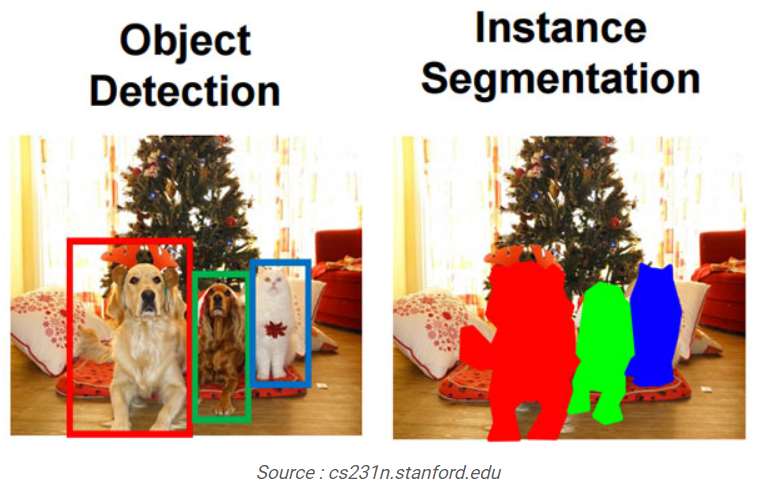

<h1> Why do we need Image Segmentation? </h1>

It is a vital technique in the medical industry where the algorithms are built to analyse patient scans, example detecting cancer cells. <br>
It is also used within traffic control systems and autonomous vehicles

<h1> Additional information </h1>

Below are two references to excellent blogs by Analytics Vidya:
<br>
<br>
[Resource1](https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/) <br>
[Resource2](https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/)

<h1> Libraries used </h1>

In [1]:
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
except:
	pass
import sys
sys.path.append(os.path.join(os.getcwd(),'modules'))

# data structures:
import pandas as pd
import numpy as np
from collections import Counter

import math

# visuals:
import seaborn as sns
import matplotlib.pyplot as plt

# images:
import cv2

# Model:
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,concatenate,Conv2DTranspose,BatchNormalization,Dropout
from keras.losses import binary_crossentropy

%matplotlib inline


Using TensorFlow backend.


<h1> Load images </h1>

In [2]:
train_data = pd.read_csv(os.path.join('./data','train.csv'))
train_data.sort_values(by='ImageId_ClassId',inplace=True)
train_data.head()


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [3]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50272 entries, 0 to 50271
Data columns (total 2 columns):
ImageId_ClassId    50272 non-null object
EncodedPixels      7095 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


In [4]:
train_data.shape


(50272, 2)

<h1> Exploratory Data Analyses </h1>

In [5]:
image_label_dict = dict()
for row in train_data.iterrows():
    image,label = row[1][0].split('_')
    if image_label_dict.get(image,0) == 0:
        image_label_dict[image] = [int(label)]
        if not isinstance(row[1][1],str):
            image_label_dict[image].pop()
    else:
        image_label_dict.get(image).append(int(label))
        if not isinstance(row[1][1],str):
            image_label_dict[image].pop()

for key,value in image_label_dict.items():
    image_label_dict[key] = [value,len(value)]


In [6]:
train_data_visuals = pd.DataFrame({})
train_data_visuals['image_id'] = list(image_label_dict.keys())
train_data_visuals['defect_types'] = train_data_visuals['image_id'].apply(lambda x: image_label_dict.get(x)[0])
train_data_visuals['defect_count'] = train_data_visuals['image_id'].apply(lambda x: image_label_dict.get(x)[1])
train_data_visuals['image_width'] = train_data_visuals['image_id'].apply(lambda x: cv2.imread(os.path.join('./data/train_imgs',x)).shape[1])
train_data_visuals['image_height'] = train_data_visuals['image_id'].apply(lambda x: cv2.imread(os.path.join('./data/train_imgs',x)).shape[0])


In [7]:
EncodedPixels = dict()
for image in image_label_dict.keys():
    counter = 0
    for e in list(train_data[train_data['ImageId_ClassId'].apply(lambda x: x.split('_')[0])==image]['EncodedPixels'].values):
        if isinstance(e,str):
            if EncodedPixels.get(image,0) == 0:
                EncodedPixels[image] = [e]
            else:
                EncodedPixels.get(image).append(e)
        else:
            counter += 1
            if counter == 4:
                EncodedPixels[image] = ''


In [8]:
train_data_visuals = train_data_visuals.merge(pd.DataFrame(list(EncodedPixels.items()),columns=['image_id','encodedpixels']),how='inner',on='image_id')


In [9]:
train_data_visuals.head()


,image_id,defect_types,defect_count,image_width,image_height,encodedpixels
0,0002cc93b.jpg,[1],1,1600,256,[29102 12 29346 24 29602 24 29858 24 30114 24 ...
1,00031f466.jpg,[],0,1600,256,
2,000418bfc.jpg,[],0,1600,256,
3,000789191.jpg,[],0,1600,256,
4,0007a71bf.jpg,[3],1,1600,256,[18661 28 18863 82 19091 110 19347 110 19603 1...


Originally there were over 50000 image records, but after restructuring the data to get each line item to present an image this got reduced to just over 12000 records

In [10]:
train_data_visuals.shape


(12568, 6)

In [11]:
print('Ratio of material that do not have any defects: {} %'.format(round((dict(Counter(train_data_visuals['defect_count'].apply(lambda x: 1 if x > 0 else 0))).get(0)/train_data_visuals.shape[0])*100,2)))
print('Ratio of material that do have defects: {} %'.format(round((dict(Counter(train_data_visuals['defect_count'].apply(lambda x: 1 if x > 0 else 0))).get(1)/train_data_visuals.shape[0])*100,2)))


Ratio of material that do not have any defects: 46.96 %
Ratio of material that do have defects: 53.04 %


The image below show that a bulk of the images in the dataset either has no defects or just one defect

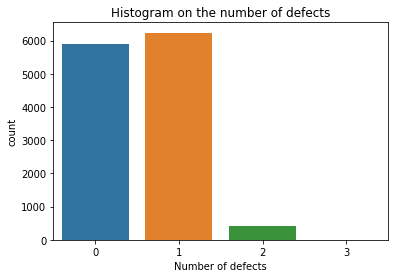

In [12]:
sns.countplot(train_data_visuals['defect_count'])
plt.title('Histogram on the number of defects')
plt.xlabel('Number of defects')
plt.show()


In [13]:
Counter(train_data_visuals['defect_count'])


Counter({1: 6239, 0: 5902, 2: 425, 3: 2})

The image below shows the distribution over the various defect combinations. The top 3 indicates that images predominantly either have no defects, one defect of type 3, or one defect of type 1

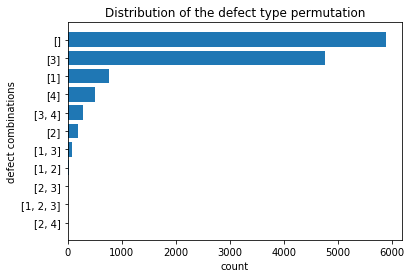

[(1, '[2, 4]'),
 (2, '[1, 2, 3]'),
 (14, '[2, 3]'),
 (35, '[1, 2]'),
 (91, '[1, 3]'),
 (195, '[2]'),
 (284, '[3, 4]'),
 (516, '[4]'),
 (769, '[1]'),
 (4759, '[3]'),
 (5902, '[]')]

In [14]:
X = list()
Y = list()
for x,y in sorted([(value,key) for key,value in dict(Counter(train_data_visuals['defect_types'].astype(str))).items()],reverse=False):
    X.append(x)
    Y.append(y)

plt.barh(y=Y,width=X)
plt.title('Distribution of the defect type permutation')
plt.xlabel('count')
plt.ylabel('defect combinations')
plt.show()
sorted([(value,key) for key,value in dict(Counter(train_data_visuals['defect_types'].astype(str))).items()],reverse=False)


The image below shows the distribution of the occurrence of the defect types within the steel sheets 

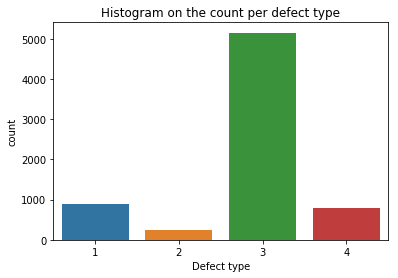

In [15]:
count_per_defect = list()
for item in list(train_data_visuals['defect_types']):
    count_per_defect += item

sns.countplot(count_per_defect)
plt.title('Histogram on the count per defect type')
plt.xlabel('Defect type')
plt.show()


In [16]:
Counter(count_per_defect)


Counter({1: 897, 3: 5150, 4: 801, 2: 247})

The mean Dice coefficient will be used to measure the performance of the model.<br>
The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:<br>
<br>
2∗|X∩Y|/|X|+|Y|
<br>
<br>
where X is the predicted set of pixels and Y is the ground truth. <br>
The Dice coefficient is defined to be 1 when both X and Y are empty.<br>
<br>
EncodedPixels<br>
In order to reduce the submission file size, the metric uses run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices, pairs of values that contain a start position and a run length will be generated. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

<h1> Helper Functions </h1>

The function 'rle2mask' takes a run length encoded pixel text string and outputs a binary mask, having 1 for the area where the defect occurs and 0 for the background.<br>
<br>
The function 'mask2rle' takes the binary mask and converts it back to the rle - run length encoded pixel string.<br>
<br>
The assert statements confirms that the full round encoding passes

In [17]:
def mask2rle(mask):
    '''
    mask: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    if len(mask_rle) == 0:
        return np.zeros(shape[0]*shape[1], dtype=np.uint8).reshape(shape).T
    else:    
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            mask[lo:hi] = 1
        mask = mask.reshape(shape).T
        return mask

try:
    assert '1 3 10 5' == mask2rle(rle2mask('1 3 10 5'))
    assert '1 1' == mask2rle(rle2mask('1 1'))
    print('Function mask is good')
except AssertionError as e:
    print('Error in function mask')        


Function mask is good


The set of functions below forms the loss function that the model will use to optimize the neural network

In [18]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = np.ravel(y_true)
    y_pred_f = np.ravel(y_pred)
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = np.ravel(y_true)
    y_pred_f = np.ravel(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * np.sum(intersection) + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
    return 1. - score

def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


Here the image masks will be mapped over the actual images to highlight the areas on the image where defects occur.<br>
<br>
Red - is for defect class 1<br>
Green - is for defect class 2<br>
Blue - is for defect class 3<br>
Pink - is for defect class4

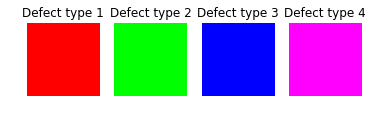

In [19]:
color_scheme = {1:(255,0,0),2:(0,255,0),3:(0,0,255),4:(255,0,255)}
for i,c in color_scheme.items():
    plt.subplot(1,4,i)
    plt.axis('off')
    plt.imshow(np.ones((20, 20, 3), dtype=np.uint8)*c)
    plt.title('Defect type {}'.format(i))
plt.show()


Helper functions to map the binary masks over the actual image

In [20]:
def mask_to_contours(image, mask, color):
    """ Converts a mask to contours using OpenCV and draws it on the image
    """ 
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, color, 2)        
    return image

def apply_masks(file_name, encodings, labels):
    if not isinstance(encodings,list):
        encodings = list()
    if not isinstance(labels,list):
        labels = list()
    # reading in the image
    image = cv2.imread(os.path.join('./data/train_imgs',file_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = [rle2mask(rle) for rle in encodings]

    for mask,label in zip(masks,labels):
        image = mask_to_contours(image=image, mask=mask, color=color_scheme.get(label,(0,0,0)))
    return image


<h1> Plotting images with the mask overlay </h1>

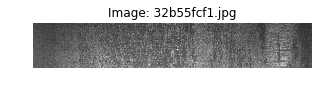

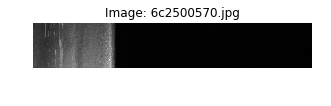

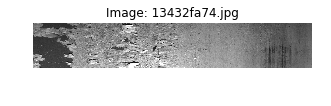

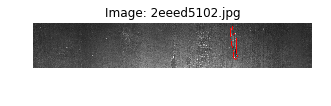

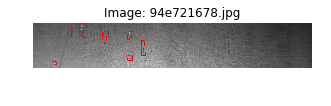

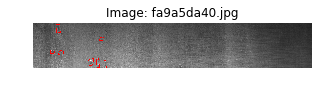

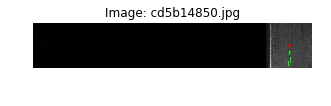

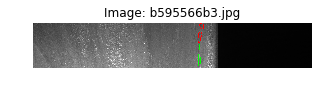

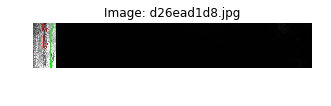

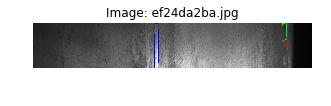

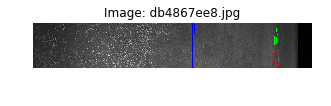

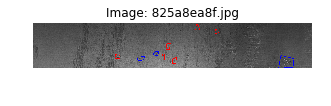

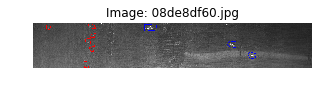

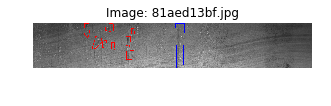

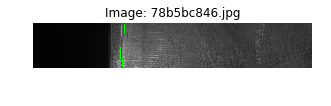

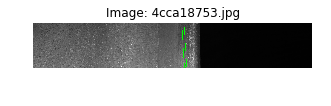

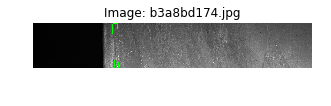

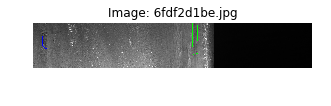

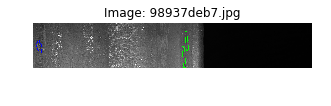

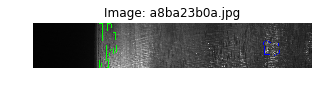

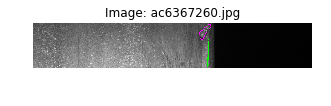

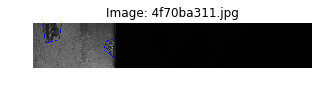

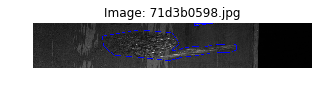

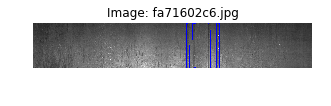

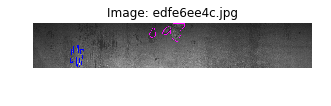

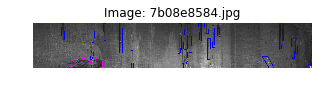

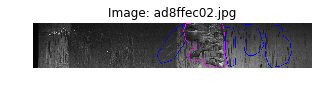

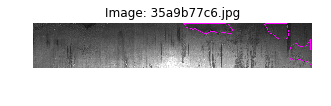

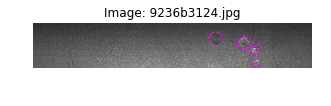

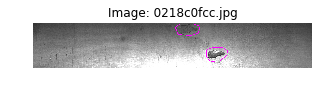

In [21]:
for permutation in np.unique(train_data_visuals['defect_types'].values):      
    data = train_data_visuals[train_data_visuals['defect_types'].apply(lambda x: str(x)) == str(permutation)]
    
    if data.shape[0] > 2:
        data = data.sample(n=3)
    elif data.shape[0] == 2:
        data = data.sample(n=2)
    else:
        data = data.sample(n=1)               
    
    for row in data.iterrows():
        plt.figure(figsize=(5,5))
        plt.axis('off')
        plt.title('Image: ' + str(row[1][0]))
        plt.imshow(apply_masks(file_name=row[1][0],encodings=row[1][5],labels=row[1][1]))
        plt.xlabel('defect types: ' + str(row[1][1]))
        plt.show()

In [22]:
del train_data


Split the data into training and testing

In [23]:
training_set,validation_set = train_test_split(train_data_visuals,
                                                test_size=0.2,
                                                shuffle=True)

print('Train data size: {}'.format(training_set.shape))
print('Validation data size: {}'.format(validation_set.shape))


Train data size: (10054, 6)
Validation data size: (2514, 6)


In [24]:
dict(Counter(training_set['defect_types'].apply(lambda x: str(x))))


{'[]': 4675,
 '[4]': 426,
 '[3]': 3821,
 '[3, 4]': 229,
 '[1]': 634,
 '[1, 3]': 69,
 '[2]': 159,
 '[2, 3]': 13,
 '[1, 2]': 26,
 '[2, 4]': 1,
 '[1, 2, 3]': 1}

In [25]:
dict(Counter(validation_set['defect_types'].apply(lambda x: str(x))))


{'[]': 1227,
 '[3]': 938,
 '[1]': 135,
 '[3, 4]': 55,
 '[2]': 36,
 '[1, 2]': 9,
 '[4]': 90,
 '[1, 3]': 22,
 '[1, 2, 3]': 1,
 '[2, 3]': 1}

<h1> Generator function </h1>

The generator function is more memory efficient and it will be used to feed the model in a batch by batch fashion.

In [52]:
def data_generator(batch_size,mode,data,size):
    data_set_index = data.index.values
    start = 0
    batch = batch_size
    global batch_X
    global batch_Y
    batch_X = list()
    batch_Y = list() 
    while True: 
        if mode == 'training':
            batch_images = np.array(data.iloc[start:batch,[0,5]]['image_id'].apply(lambda x:cv2.imread(filename=os.path.join('./data/train_imgs',x))))
            batch_images = np.array(list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB),batch_images))) #get the channel ordering right
            batch_images = np.array(list(map(lambda x: cv2.resize(x,(size,size)),batch_images)))

            batch_masks = np.array(data.iloc[start:batch,[0,5]]['encodedpixels'].apply(lambda x: np.array([rle2mask(rle) for rle in list(x)]) if len(x) > 0 else np.array([np.zeros(shape=(256,1600))])))
            batch_masks = [x.transpose((1,2,0)) for x in batch_masks]
            batch_masks = list(map(lambda x: cv2.resize(x,(size,size)),batch_masks))
            batch_masks = list(map(lambda x: [[[np.array(x)]]],batch_masks))

            batch_X.append(batch_images)
            batch_Y.append(batch_masks)
            print('-------------')
            yield np.squeeze(np.array(batch_X),axis=0),batch_Y
            start = batch
            batch += batch_size 
            batch_images, batch_masks = np.array([])

        if mode == 'prediction':
            batch_images = np.array(data.iloc[start:batch,[0,5]]['image_id'].apply(lambda x:cv2.imread(filename=os.path.join('./data/test_imgs',x))))
            batch_images = np.array(list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB),batch_images))) #get the channel ordering right
            batch_images = np.array(list(map(lambda x: cv2.resize(x,(size,size)),batch_images)))

            batch_X.append(batch_images)
            print('-------------')
            yield np.array(batch_X)
            start = batch
            batch += batch_size 
            batch_images = np.array([]) 



In [53]:
batch_size = 30
training_batch_generator = data_generator(batch_size=batch_size,mode='training',data=training_set,size=256)
validation_batch_generator = data_generator(batch_size=batch_size,mode='training',data=validation_set,size=256)


In [54]:
for x,y in data_generator(batch_size=batch_size,mode='training',data=training_set,size=256):
    break    

-------------


In [55]:
x.shape

(30, 256, 256, 3)

In [72]:
np.array(y).shape

ValueError: could not broadcast input array from shape (256,256,2) into shape (256,256)

<h1> Building the neural network </h1>

In [ ]:
inputs = Input(shape=(256,256,3))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])


In [ ]:
model.summary()


In [ ]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
H = model.fit_generator(generator=training_batch_generator, 
                        steps_per_epoch=math.ceil(training_set.shape[0]/batch_size), 
                        epochs=3, 
                        verbose=1, 
                        callbacks=None, 
                        validation_data=validation_batch_generator, 
                        validation_steps=math.ceil(validation_set.shape[0]/batch_size)
                        )
